# Faster R-CNN

## Setup
Import libraries

In [1]:
import cv2
import torch, torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import os
import json
import numpy as np
from tqdm import tqdm

## Pre-Training

Load Faster R-CNN model with pretrained resnet50 (+fpn) backbone

In [2]:
rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
rcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Change final ROI layer to predict the categories we are looking for

In [4]:
rcnn.roi_heads.box_predictor = FastRCNNPredictor(1024, 4)
rcnn.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=4, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=16, bias=True)
)

Load 300 images from the dataset. Looks like the most common box category is cyclists, followed by pedestrians

In [15]:
i = 0
num = 300
images = []
targets = []

labels_list = ['__background__','pedestrian', 'cyclist', 'motorcyclist', 'tricyclist', 'wheelchairuser', 'mopedrider']
cyclist_cnt, ped_cnt, other_cnt = 0, 0, 0

directory = list(os.walk('../dataset/labels'))
for f in directory[0][2]:
    if i >= num:
        break
    i += 1

    with open('../dataset/labels/' + f) as file:
        jsonfile = json.load(file)

        image = cv2.imread('../dataset/images/' +jsonfile['imagename'])
        transform = transforms.Compose([transforms.ToTensor()])
        images.append(transform(image))

        dict = {}
        boxes, labels = [], []
        for bbox in jsonfile['children']:
            if bbox['identity'] == 'cyclist':
                cyclist_cnt += 1
            elif bbox['identity'] == 'pedestrian':
                ped_cnt += 1
            else:
                other_cnt += 1
            label = labels_list.index(bbox['identity'])
            if label >= 3:
                label = 3
            labels.append(label)
            boxes.append([bbox['mincol'], bbox['minrow'], bbox['maxcol'], bbox['maxrow']])
        targets.append({'boxes': torch.tensor(boxes), 'labels': torch.tensor(labels)})
print('cyclists: {}, pedestrians: {}, other: {}'.format(cyclist_cnt, ped_cnt, other_cnt))
print(targets)

cyclists: 502, pedestrians: 164, other: 20
[{'boxes': tensor([[1034,  409, 1056,  470],
        [1767,  317, 1930,  822],
        [1673,  360, 1816,  654],
        [1266,  410, 1289,  478],
        [1173,  403, 1191,  478],
        [1058,  411, 1085,  476]]), 'labels': tensor([2, 1, 1, 1, 1, 1])}, {'boxes': tensor([[1024,  400, 1047,  463],
        [1817,  324, 1972,  711],
        [1263,  402, 1284,  473],
        [1158,  393, 1188,  472],
        [1044,  402, 1069,  472]]), 'labels': tensor([2, 1, 1, 1, 1])}, {'boxes': tensor([[1007,  400, 1032,  466],
        [1028,  403, 1053,  465],
        [1253,  401, 1275,  476],
        [1144,  392, 1176,  478],
        [1022,  402, 1049,  475]]), 'labels': tensor([2, 2, 1, 1, 1])}, {'boxes': tensor([[ 981,  399, 1008,  468],
        [1001,  402, 1027,  467],
        [1221,  401, 1257,  481],
        [1118,  390, 1141,  479],
        [ 989,  401, 1017,  483]]), 'labels': tensor([2, 2, 1, 1, 1])}, {'boxes': tensor([[ 948,  411,  976,  484],
   

## Training

Fine tune our pretrained model on 100 images (with batch size of 5) for 10 epochs. Also save model parameters 

In [6]:
optimizer = torch.optim.SGD(rcnn.parameters(), lr=0.001, momentum=0.9)

In [7]:
loss_list = []
best_loss = 1000
file = os.path.join(os.getcwd(), 'rcnn.pt')
for epoch in range(10):
    rcnn.train()
    loss_sublist = []
    for i in range(20):
        # print(i)
        cur = i*5
        X = images[cur:cur+5]
        y = targets[cur:cur+5]
        
        j = 0
        while j < len(y):
            if len(y[j]['boxes'].detach().numpy()) == 0:
                X.pop(j)
                y.pop(j)
                j -= 1
            j += 1
        if len(y) == 0:
            continue

        loss = rcnn(X, y)
        # print(loss)
        losses = sum(l for l in loss.values())
        print(str(loss['loss_classifier'].item()), str(loss['loss_box_reg'].item()), str(loss['loss_objectness'].item()), str(loss['loss_rpn_box_reg'].item()))
        loss_sublist.append(losses.item())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))
    if np.mean(loss_sublist) < best_loss:
        torch.save(rcnn.state_dict(), file)
        best_loss = np.mean(loss_sublist)
        print('current model saved')
    
    print('epoch '+str(epoch)+' combined loss: '+str(loss_list[-1]))

1.262619137763977 0.4455714225769043 0.05476384609937668 0.0091832485049963
1.123842716217041 0.45744141936302185 0.04873857647180557 0.009630521759390831
0.8951865434646606 0.5213223099708557 0.06247801333665848 0.02333628199994564
0.7002859711647034 0.5478110909461975 0.024590954184532166 0.019835377112030983
0.46765321493148804 0.3707922101020813 0.031063109636306763 0.021729586645960808
0.315874844789505 0.15599028766155243 0.0200161375105381 0.0036787614226341248
0.5607535243034363 0.5783387422561646 0.10014061629772186 0.06385263055562973
0.5790821313858032 0.5408587455749512 0.03018638864159584 0.030399387702345848
0.38749435544013977 0.3372371792793274 0.010555592365562916 0.02364281192421913
0.30928903818130493 0.2677081227302551 0.009379263035953045 0.008796341717243195
0.27622008323669434 0.2630833685398102 0.016464512795209885 0.007251773960888386
0.15275582671165466 0.16106338798999786 0.010720589198172092 0.0013280629646033049
0.1862141340970993 0.17902205884456635 0.0059

## Evaluation

Let's visualize how our model performs on training images and non-training images. Here, I've tweaked the code below to save 30 images each to folders images1/, images2/ and images3/, respectively being training, non-training and non-training

tensor([0.6232, 0.5935, 0.4973, 0.4753, 0.4606, 0.4580, 0.4499, 0.3964, 0.3782,
        0.3368, 0.3363, 0.3309, 0.3304, 0.3202, 0.3201, 0.2980, 0.2922, 0.2850,
        0.2802, 0.2760, 0.2466, 0.2380, 0.2264, 0.2223, 0.2154, 0.1924, 0.1870,
        0.1845, 0.1774, 0.1615, 0.1514, 0.1414, 0.1407, 0.1400, 0.1349, 0.1254,
        0.1210, 0.1182, 0.1154, 0.1005, 0.0995, 0.0982, 0.0950, 0.0936, 0.0922,
        0.0914, 0.0889, 0.0874, 0.0868, 0.0856, 0.0850, 0.0813, 0.0811, 0.0801,
        0.0795, 0.0785, 0.0773, 0.0747, 0.0699, 0.0697, 0.0673, 0.0660, 0.0652,
        0.0645, 0.0645, 0.0642, 0.0626, 0.0613, 0.0611, 0.0606, 0.0597, 0.0592,
        0.0579, 0.0577, 0.0567, 0.0566, 0.0563, 0.0532, 0.0519, 0.0504],
       grad_fn=<IndexBackward0>)


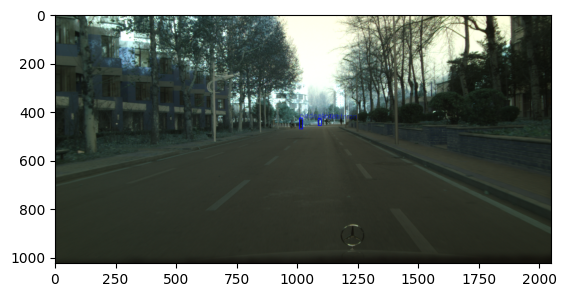

tensor([0.7051, 0.4920, 0.4785, 0.4226, 0.3541, 0.3348, 0.3265, 0.3231, 0.3203,
        0.3007, 0.2918, 0.2875, 0.2694, 0.2548, 0.2547, 0.2485, 0.2414, 0.2233,
        0.2085, 0.2007, 0.1870, 0.1742, 0.1723, 0.1696, 0.1590, 0.1589, 0.1558,
        0.1536, 0.1506, 0.1494, 0.1453, 0.1426, 0.1392, 0.1299, 0.1298, 0.1134,
        0.1115, 0.1080, 0.1069, 0.1055, 0.1053, 0.1052, 0.0973, 0.0962, 0.0953,
        0.0907, 0.0902, 0.0852, 0.0844, 0.0834, 0.0797, 0.0788, 0.0776, 0.0770,
        0.0766, 0.0754, 0.0749, 0.0721, 0.0707, 0.0654, 0.0639, 0.0612, 0.0602,
        0.0598, 0.0590, 0.0587, 0.0580, 0.0568, 0.0562, 0.0527, 0.0510],
       grad_fn=<IndexBackward0>)


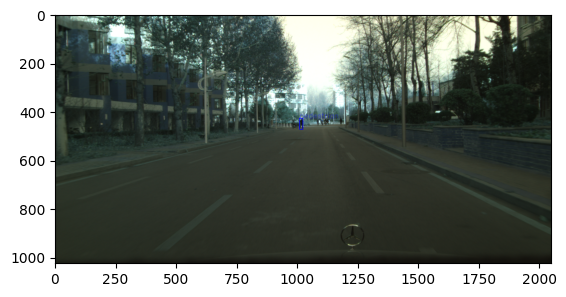

tensor([0.5601, 0.4493, 0.4026, 0.3997, 0.3988, 0.3970, 0.3953, 0.3736, 0.3302,
        0.2922, 0.2827, 0.2731, 0.2728, 0.2632, 0.2410, 0.2404, 0.2326, 0.2315,
        0.2243, 0.2166, 0.2138, 0.2063, 0.1904, 0.1884, 0.1872, 0.1845, 0.1819,
        0.1708, 0.1545, 0.1469, 0.1429, 0.1390, 0.1390, 0.1320, 0.1267, 0.1204,
        0.1116, 0.1061, 0.1001, 0.0977, 0.0973, 0.0913, 0.0900, 0.0877, 0.0856,
        0.0819, 0.0796, 0.0793, 0.0786, 0.0760, 0.0737, 0.0732, 0.0682, 0.0660,
        0.0623, 0.0612, 0.0604, 0.0595, 0.0590, 0.0590, 0.0590, 0.0561, 0.0549,
        0.0535, 0.0530, 0.0511, 0.0510, 0.0503, 0.0501],
       grad_fn=<IndexBackward0>)


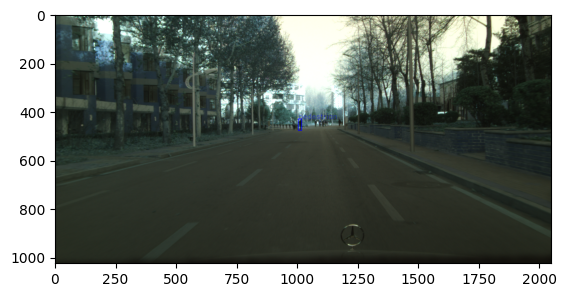

tensor([0.6448, 0.5263, 0.4782, 0.4211, 0.4032, 0.3574, 0.3257, 0.3245, 0.3176,
        0.3125, 0.2875, 0.2817, 0.2813, 0.2752, 0.2626, 0.2615, 0.2543, 0.2465,
        0.2248, 0.2187, 0.1970, 0.1930, 0.1908, 0.1875, 0.1777, 0.1755, 0.1736,
        0.1686, 0.1679, 0.1647, 0.1630, 0.1537, 0.1519, 0.1479, 0.1451, 0.1359,
        0.1332, 0.1319, 0.1295, 0.1261, 0.1223, 0.1186, 0.1186, 0.1174, 0.1171,
        0.1128, 0.1113, 0.1045, 0.0964, 0.0879, 0.0834, 0.0772, 0.0759, 0.0748,
        0.0748, 0.0733, 0.0717, 0.0713, 0.0702, 0.0684, 0.0683, 0.0659, 0.0659,
        0.0612, 0.0609, 0.0594, 0.0581, 0.0569, 0.0548, 0.0544, 0.0526, 0.0503],
       grad_fn=<IndexBackward0>)


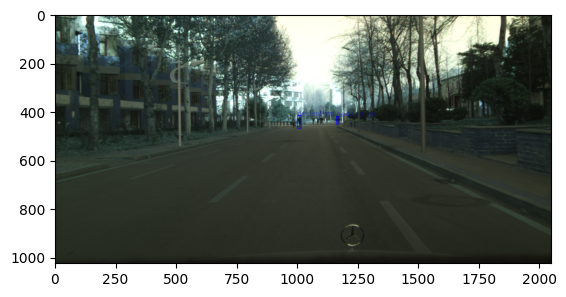

tensor([0.5590, 0.4481, 0.4089, 0.3808, 0.3764, 0.3464, 0.3433, 0.3383, 0.3170,
        0.3068, 0.2835, 0.2825, 0.2732, 0.2720, 0.2717, 0.2585, 0.2439, 0.2391,
        0.2268, 0.2080, 0.2061, 0.2041, 0.2014, 0.1986, 0.1950, 0.1929, 0.1741,
        0.1716, 0.1568, 0.1497, 0.1471, 0.1466, 0.1437, 0.1403, 0.1374, 0.1272,
        0.1200, 0.1090, 0.1086, 0.1020, 0.0954, 0.0949, 0.0949, 0.0912, 0.0883,
        0.0874, 0.0871, 0.0848, 0.0833, 0.0803, 0.0788, 0.0765, 0.0761, 0.0745,
        0.0738, 0.0692, 0.0683, 0.0672, 0.0659, 0.0645, 0.0610, 0.0606, 0.0602,
        0.0600, 0.0596, 0.0588, 0.0580, 0.0580, 0.0572, 0.0543, 0.0531, 0.0526,
        0.0522, 0.0510, 0.0504, 0.0503], grad_fn=<IndexBackward0>)


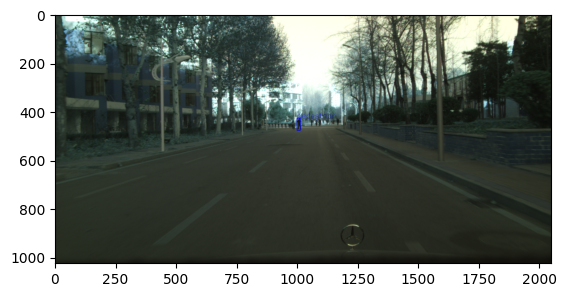

tensor([0.6121, 0.5186, 0.4261, 0.4129, 0.3813, 0.3802, 0.3646, 0.3345, 0.3326,
        0.3217, 0.3208, 0.3171, 0.3146, 0.3068, 0.2785, 0.2709, 0.2668, 0.2608,
        0.2605, 0.2535, 0.2172, 0.2053, 0.1992, 0.1977, 0.1867, 0.1841, 0.1799,
        0.1764, 0.1735, 0.1686, 0.1615, 0.1528, 0.1471, 0.1424, 0.1335, 0.1265,
        0.1253, 0.1237, 0.1169, 0.1140, 0.1121, 0.1100, 0.1090, 0.1076, 0.1065,
        0.1008, 0.0995, 0.0979, 0.0935, 0.0933, 0.0921, 0.0918, 0.0894, 0.0878,
        0.0873, 0.0827, 0.0813, 0.0813, 0.0805, 0.0797, 0.0778, 0.0731, 0.0731,
        0.0709, 0.0691, 0.0683, 0.0682, 0.0675, 0.0667, 0.0645, 0.0632, 0.0620,
        0.0611, 0.0603, 0.0601, 0.0591, 0.0583, 0.0568, 0.0563, 0.0561, 0.0556,
        0.0547, 0.0546, 0.0538, 0.0533, 0.0529, 0.0502],
       grad_fn=<IndexBackward0>)


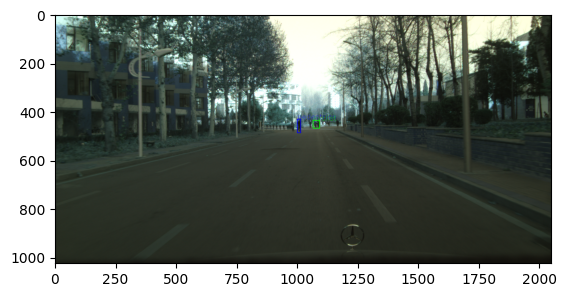

tensor([0.7195, 0.5392, 0.4587, 0.4424, 0.3901, 0.3685, 0.3514, 0.3373, 0.2919,
        0.2918, 0.2862, 0.2810, 0.2775, 0.2744, 0.2726, 0.2674, 0.2650, 0.2549,
        0.2544, 0.2427, 0.2400, 0.2288, 0.2162, 0.2148, 0.2093, 0.2074, 0.2066,
        0.1966, 0.1890, 0.1858, 0.1817, 0.1735, 0.1704, 0.1702, 0.1691, 0.1660,
        0.1619, 0.1615, 0.1575, 0.1568, 0.1537, 0.1512, 0.1507, 0.1506, 0.1504,
        0.1451, 0.1447, 0.1364, 0.1337, 0.1286, 0.1157, 0.1157, 0.1150, 0.1123,
        0.1119, 0.1108, 0.1080, 0.1025, 0.1018, 0.0963, 0.0904, 0.0904, 0.0884,
        0.0841, 0.0837, 0.0829, 0.0783, 0.0767, 0.0762, 0.0752, 0.0722, 0.0712,
        0.0702, 0.0695, 0.0691, 0.0683, 0.0665, 0.0664, 0.0626, 0.0623, 0.0620,
        0.0597, 0.0586, 0.0582, 0.0581, 0.0529, 0.0526, 0.0526, 0.0517],
       grad_fn=<IndexBackward0>)


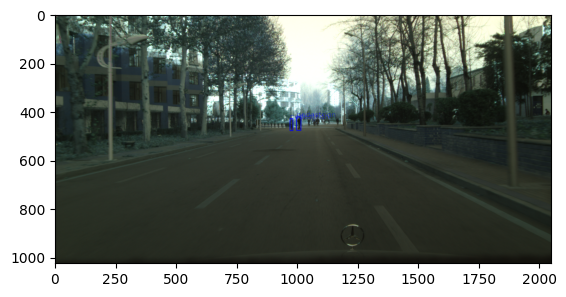

tensor([0.7634, 0.6901, 0.4565, 0.4561, 0.4378, 0.4152, 0.3613, 0.3607, 0.3304,
        0.3296, 0.3260, 0.3138, 0.3084, 0.3018, 0.2983, 0.2883, 0.2858, 0.2737,
        0.2576, 0.2563, 0.2546, 0.2445, 0.2411, 0.2309, 0.2254, 0.2224, 0.2112,
        0.2048, 0.1934, 0.1888, 0.1813, 0.1777, 0.1776, 0.1639, 0.1604, 0.1523,
        0.1432, 0.1388, 0.1349, 0.1331, 0.1319, 0.1272, 0.1246, 0.1168, 0.1116,
        0.1114, 0.1104, 0.1068, 0.1062, 0.1057, 0.1012, 0.0993, 0.0930, 0.0841,
        0.0839, 0.0818, 0.0815, 0.0809, 0.0778, 0.0724, 0.0709, 0.0652, 0.0645,
        0.0618, 0.0615, 0.0600, 0.0595, 0.0593, 0.0588, 0.0583, 0.0578, 0.0543,
        0.0534, 0.0529, 0.0521, 0.0517, 0.0516, 0.0513, 0.0509],
       grad_fn=<IndexBackward0>)


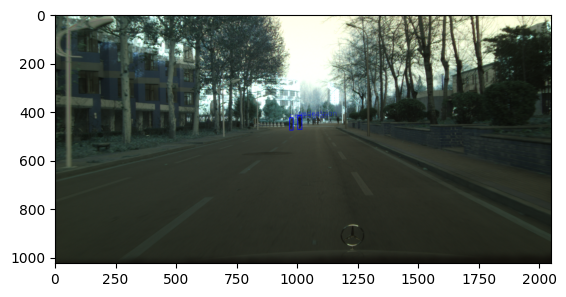

tensor([0.7507, 0.5784, 0.4315, 0.3834, 0.3374, 0.3150, 0.3134, 0.3134, 0.3042,
        0.2989, 0.2910, 0.2502, 0.2460, 0.2387, 0.2309, 0.2239, 0.2217, 0.2118,
        0.2118, 0.2104, 0.2041, 0.2033, 0.2028, 0.1980, 0.1943, 0.1899, 0.1812,
        0.1783, 0.1748, 0.1524, 0.1447, 0.1348, 0.1321, 0.1307, 0.1268, 0.1259,
        0.1255, 0.1250, 0.1200, 0.1158, 0.1132, 0.1089, 0.1032, 0.0996, 0.0990,
        0.0977, 0.0960, 0.0930, 0.0919, 0.0872, 0.0866, 0.0848, 0.0816, 0.0813,
        0.0776, 0.0773, 0.0730, 0.0729, 0.0716, 0.0716, 0.0704, 0.0689, 0.0686,
        0.0666, 0.0659, 0.0645, 0.0632, 0.0631, 0.0621, 0.0619, 0.0614, 0.0609,
        0.0596, 0.0588, 0.0581, 0.0564, 0.0547, 0.0542, 0.0542, 0.0535, 0.0528,
        0.0512], grad_fn=<IndexBackward0>)


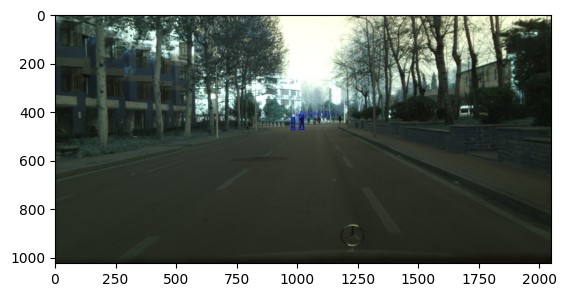

tensor([0.6362, 0.6274, 0.6026, 0.4933, 0.4787, 0.4767, 0.4589, 0.4231, 0.3971,
        0.3949, 0.3819, 0.3548, 0.3322, 0.3012, 0.3002, 0.2841, 0.2813, 0.2761,
        0.2704, 0.2683, 0.2674, 0.2477, 0.2449, 0.2345, 0.2329, 0.2236, 0.2093,
        0.2026, 0.2006, 0.1866, 0.1861, 0.1841, 0.1835, 0.1787, 0.1717, 0.1704,
        0.1684, 0.1644, 0.1641, 0.1630, 0.1549, 0.1475, 0.1470, 0.1436, 0.1415,
        0.1389, 0.1379, 0.1299, 0.1232, 0.1116, 0.1095, 0.1088, 0.1072, 0.1058,
        0.1052, 0.1043, 0.1033, 0.1018, 0.1000, 0.0901, 0.0825, 0.0803, 0.0789,
        0.0779, 0.0762, 0.0759, 0.0738, 0.0737, 0.0726, 0.0685, 0.0673, 0.0659,
        0.0647, 0.0609, 0.0603, 0.0598, 0.0587, 0.0584, 0.0584, 0.0582, 0.0578,
        0.0564, 0.0557, 0.0540, 0.0536, 0.0524, 0.0514, 0.0507],
       grad_fn=<IndexBackward0>)


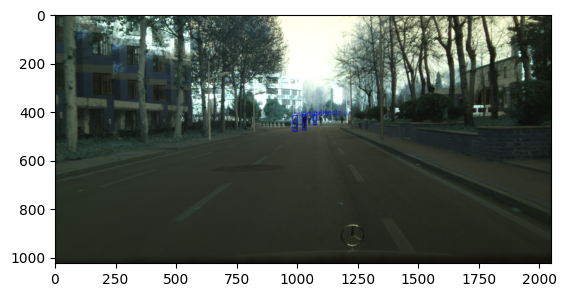

tensor([0.8529, 0.7765, 0.4544, 0.4425, 0.4196, 0.3945, 0.3645, 0.3636, 0.3484,
        0.3247, 0.3197, 0.3162, 0.3082, 0.3029, 0.2795, 0.2665, 0.2635, 0.2607,
        0.2445, 0.2383, 0.2378, 0.2277, 0.2273, 0.2219, 0.2190, 0.2142, 0.2029,
        0.1827, 0.1780, 0.1741, 0.1664, 0.1584, 0.1428, 0.1413, 0.1316, 0.1214,
        0.1200, 0.1172, 0.1126, 0.1024, 0.1012, 0.0971, 0.0840, 0.0836, 0.0821,
        0.0810, 0.0798, 0.0754, 0.0749, 0.0730, 0.0727, 0.0725, 0.0718, 0.0648,
        0.0628, 0.0624, 0.0617, 0.0615, 0.0615, 0.0615, 0.0579, 0.0568, 0.0563,
        0.0543, 0.0533, 0.0531, 0.0528, 0.0522], grad_fn=<IndexBackward0>)


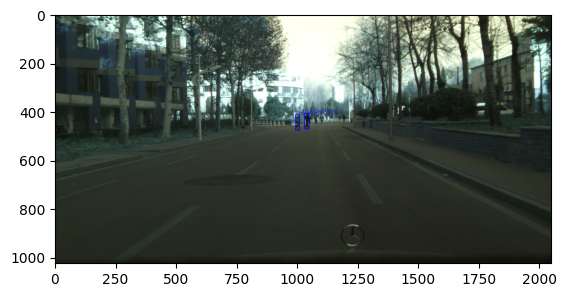

tensor([0.6508, 0.6075, 0.5128, 0.4960, 0.4630, 0.4451, 0.4362, 0.4164, 0.4137,
        0.4090, 0.3630, 0.3544, 0.3484, 0.3476, 0.3431, 0.3183, 0.2807, 0.2742,
        0.2730, 0.2550, 0.2487, 0.2306, 0.2202, 0.2184, 0.2143, 0.1721, 0.1571,
        0.1454, 0.1450, 0.1400, 0.1349, 0.1186, 0.1162, 0.1140, 0.1085, 0.1075,
        0.1070, 0.1046, 0.0924, 0.0837, 0.0831, 0.0829, 0.0825, 0.0788, 0.0769,
        0.0735, 0.0722, 0.0720, 0.0717, 0.0699, 0.0699, 0.0686, 0.0677, 0.0664,
        0.0654, 0.0652, 0.0625, 0.0613, 0.0602, 0.0599, 0.0595, 0.0589],
       grad_fn=<IndexBackward0>)


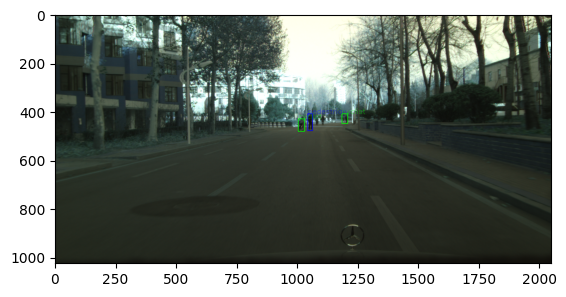

tensor([0.8470, 0.8262, 0.4981, 0.4862, 0.4823, 0.4345, 0.4340, 0.3689, 0.3624,
        0.3427, 0.3257, 0.3181, 0.2853, 0.2618, 0.2253, 0.2247, 0.2101, 0.1827,
        0.1432, 0.1348, 0.1343, 0.1332, 0.1312, 0.1151, 0.1128, 0.1096, 0.1000,
        0.0973, 0.0860, 0.0840, 0.0832, 0.0755, 0.0720, 0.0710, 0.0703, 0.0698,
        0.0651, 0.0590, 0.0551, 0.0551, 0.0546, 0.0544, 0.0526, 0.0513],
       grad_fn=<IndexBackward0>)


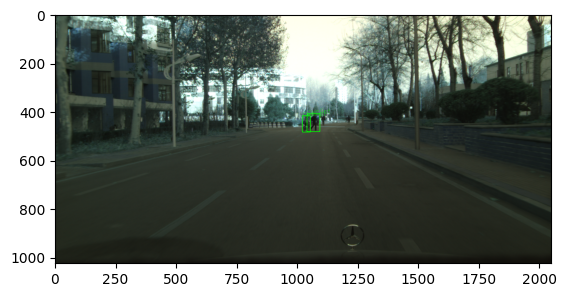

tensor([0.7803, 0.5278, 0.4347, 0.4027, 0.3619, 0.3519, 0.2948, 0.2641, 0.2137,
        0.1903, 0.1887, 0.1633, 0.1436, 0.1423, 0.1372, 0.1224, 0.1220, 0.1023,
        0.0933, 0.0841, 0.0786, 0.0741, 0.0653, 0.0588, 0.0570, 0.0543, 0.0531,
        0.0529, 0.0527, 0.0523, 0.0505, 0.0505], grad_fn=<IndexBackward0>)


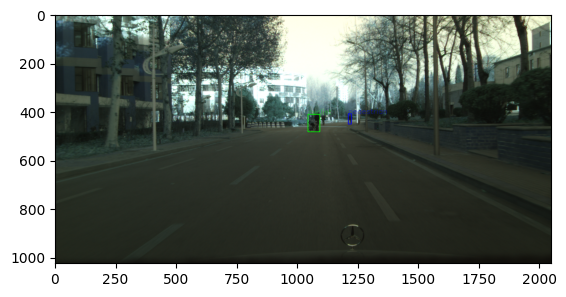

tensor([0.7482, 0.5919, 0.5803, 0.4385, 0.4004, 0.3318, 0.2888, 0.2501, 0.2295,
        0.1632, 0.1580, 0.1136, 0.1049, 0.1035, 0.0938, 0.0824, 0.0817, 0.0752,
        0.0718, 0.0717, 0.0664, 0.0649, 0.0635, 0.0633, 0.0626, 0.0622, 0.0620,
        0.0607, 0.0601, 0.0591, 0.0574, 0.0567, 0.0566, 0.0529, 0.0515],
       grad_fn=<IndexBackward0>)


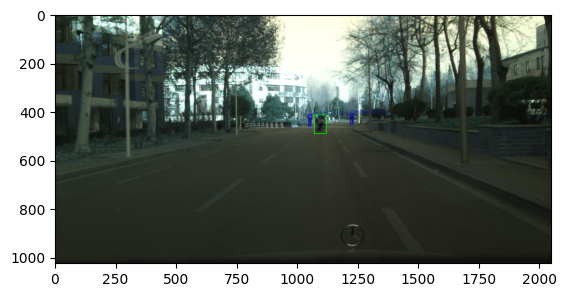

tensor([0.9009, 0.6397, 0.6304, 0.5989, 0.5639, 0.4857, 0.4770, 0.3820, 0.3320,
        0.3246, 0.3152, 0.3127, 0.3037, 0.2908, 0.2569, 0.2346, 0.2233, 0.1949,
        0.1945, 0.1918, 0.1887, 0.1600, 0.1309, 0.1264, 0.1256, 0.1106, 0.1063,
        0.0989, 0.0957, 0.0941, 0.0910, 0.0823, 0.0819, 0.0743, 0.0714, 0.0705,
        0.0637, 0.0619, 0.0608, 0.0588, 0.0585, 0.0573, 0.0563, 0.0530, 0.0511,
        0.0507, 0.0506], grad_fn=<IndexBackward0>)


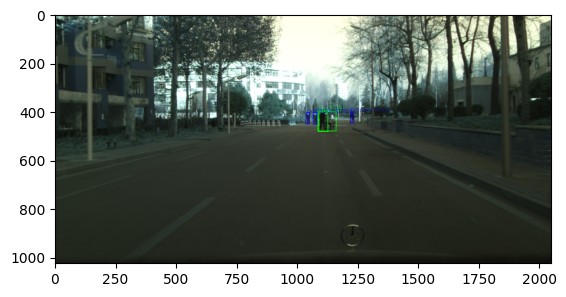

tensor([0.8880, 0.7459, 0.5754, 0.5481, 0.5224, 0.4679, 0.3942, 0.3770, 0.3717,
        0.3453, 0.3449, 0.3434, 0.2965, 0.2963, 0.2890, 0.2560, 0.2512, 0.2484,
        0.2290, 0.2281, 0.2017, 0.2015, 0.2008, 0.1980, 0.1914, 0.1613, 0.1600,
        0.1494, 0.1479, 0.1460, 0.1324, 0.1318, 0.1309, 0.1280, 0.1217, 0.1122,
        0.1103, 0.1095, 0.1091, 0.1069, 0.0892, 0.0848, 0.0824, 0.0794, 0.0794,
        0.0788, 0.0781, 0.0754, 0.0742, 0.0728, 0.0721, 0.0718, 0.0671, 0.0644,
        0.0627, 0.0624, 0.0607, 0.0597, 0.0551, 0.0543, 0.0528, 0.0519],
       grad_fn=<IndexBackward0>)


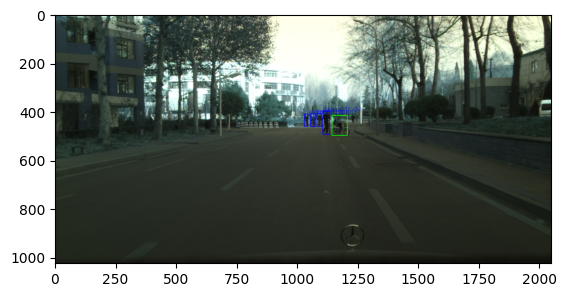

tensor([0.9477, 0.9467, 0.6753, 0.5124, 0.4898, 0.4044, 0.3742, 0.3606, 0.3598,
        0.3534, 0.3354, 0.3017, 0.2995, 0.2739, 0.2432, 0.2371, 0.2304, 0.2038,
        0.1909, 0.1829, 0.1769, 0.1740, 0.1695, 0.1665, 0.1612, 0.1596, 0.1546,
        0.1514, 0.1349, 0.1342, 0.1323, 0.1199, 0.1194, 0.1126, 0.1014, 0.0973,
        0.0973, 0.0938, 0.0871, 0.0771, 0.0609, 0.0593, 0.0589, 0.0566, 0.0560,
        0.0521], grad_fn=<IndexBackward0>)


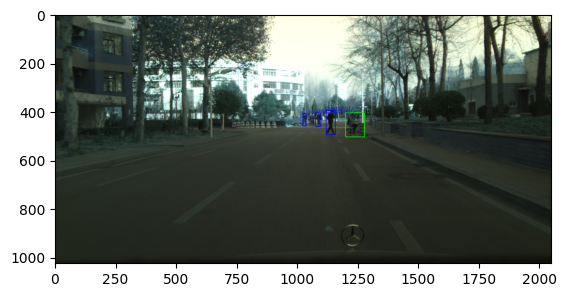

tensor([0.9441, 0.7045, 0.5867, 0.5492, 0.5245, 0.4343, 0.4137, 0.4027, 0.4021,
        0.3717, 0.3351, 0.3198, 0.3047, 0.2320, 0.2305, 0.2265, 0.2147, 0.2126,
        0.2006, 0.2001, 0.1959, 0.1823, 0.1706, 0.1627, 0.1608, 0.1532, 0.1488,
        0.1411, 0.1356, 0.1298, 0.1290, 0.1269, 0.1255, 0.1247, 0.1243, 0.1230,
        0.1228, 0.1205, 0.1057, 0.1033, 0.1019, 0.1005, 0.0992, 0.0954, 0.0951,
        0.0883, 0.0873, 0.0840, 0.0767, 0.0755, 0.0752, 0.0710, 0.0667, 0.0640,
        0.0603, 0.0544, 0.0542, 0.0523, 0.0521], grad_fn=<IndexBackward0>)


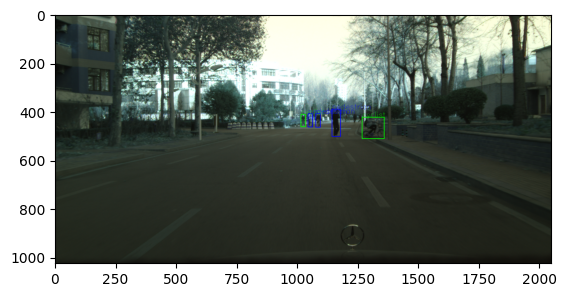

tensor([0.9524, 0.5585, 0.5102, 0.4934, 0.4809, 0.4062, 0.4044, 0.4025, 0.3819,
        0.3779, 0.3735, 0.3617, 0.3369, 0.3267, 0.2844, 0.2807, 0.2799, 0.2644,
        0.2236, 0.2008, 0.1981, 0.1968, 0.1782, 0.1779, 0.1657, 0.1525, 0.1488,
        0.1484, 0.1410, 0.1389, 0.1375, 0.1341, 0.1247, 0.1237, 0.1236, 0.1125,
        0.1067, 0.1006, 0.0994, 0.0954, 0.0943, 0.0927, 0.0908, 0.0901, 0.0898,
        0.0846, 0.0801, 0.0775, 0.0709, 0.0671, 0.0645, 0.0632, 0.0614, 0.0603,
        0.0586, 0.0552, 0.0538, 0.0535, 0.0515, 0.0508, 0.0505],
       grad_fn=<IndexBackward0>)


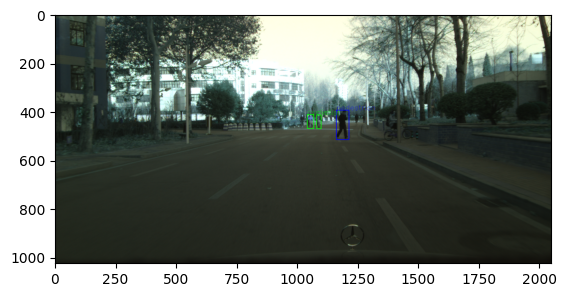

tensor([0.9590, 0.6814, 0.6182, 0.5752, 0.4943, 0.4812, 0.4807, 0.4122, 0.3865,
        0.3850, 0.3788, 0.3693, 0.3439, 0.3222, 0.2605, 0.2589, 0.2582, 0.2570,
        0.2440, 0.2393, 0.2356, 0.2151, 0.2142, 0.2137, 0.2095, 0.2028, 0.2018,
        0.1912, 0.1872, 0.1820, 0.1797, 0.1410, 0.1295, 0.1271, 0.1265, 0.1252,
        0.1217, 0.1215, 0.1179, 0.1169, 0.1163, 0.1145, 0.1144, 0.1142, 0.1133,
        0.1126, 0.1124, 0.1099, 0.1091, 0.1087, 0.1030, 0.1021, 0.0981, 0.0899,
        0.0897, 0.0851, 0.0825, 0.0824, 0.0817, 0.0762, 0.0756, 0.0738, 0.0722,
        0.0704, 0.0687, 0.0635, 0.0621, 0.0603, 0.0601, 0.0595, 0.0592, 0.0591,
        0.0588, 0.0584, 0.0562, 0.0552, 0.0532, 0.0527, 0.0522, 0.0510, 0.0509,
        0.0509, 0.0500], grad_fn=<IndexBackward0>)


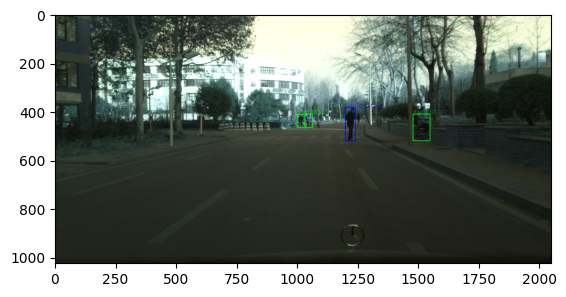

tensor([0.9538, 0.8000, 0.6738, 0.6693, 0.6590, 0.6262, 0.5665, 0.4761, 0.4242,
        0.4194, 0.4050, 0.3933, 0.3470, 0.3252, 0.3078, 0.2788, 0.2592, 0.2213,
        0.2205, 0.2172, 0.2031, 0.1959, 0.1914, 0.1824, 0.1746, 0.1614, 0.1568,
        0.1500, 0.1411, 0.1403, 0.1354, 0.1331, 0.1303, 0.1219, 0.1120, 0.1119,
        0.1115, 0.1085, 0.1080, 0.1068, 0.1044, 0.1035, 0.1018, 0.1018, 0.1010,
        0.0930, 0.0889, 0.0884, 0.0837, 0.0831, 0.0821, 0.0792, 0.0767, 0.0765,
        0.0745, 0.0743, 0.0710, 0.0707, 0.0697, 0.0690, 0.0680, 0.0678, 0.0675,
        0.0655, 0.0649, 0.0619, 0.0618, 0.0607, 0.0598, 0.0597, 0.0571, 0.0559,
        0.0542, 0.0537, 0.0528, 0.0524, 0.0524, 0.0522, 0.0519, 0.0518, 0.0510,
        0.0500], grad_fn=<IndexBackward0>)


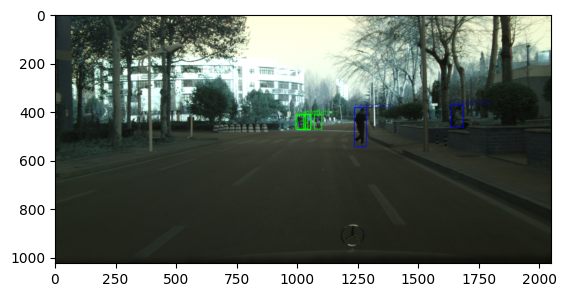

tensor([0.9518, 0.7270, 0.6295, 0.6181, 0.5645, 0.5458, 0.5257, 0.5002, 0.4656,
        0.4513, 0.4276, 0.4235, 0.3960, 0.3778, 0.3774, 0.3672, 0.2932, 0.2794,
        0.2641, 0.2423, 0.2219, 0.2217, 0.2019, 0.1992, 0.1936, 0.1927, 0.1756,
        0.1728, 0.1716, 0.1670, 0.1639, 0.1585, 0.1551, 0.1493, 0.1434, 0.1433,
        0.1427, 0.1401, 0.1292, 0.1269, 0.1156, 0.1098, 0.1077, 0.1070, 0.1043,
        0.1005, 0.0978, 0.0972, 0.0968, 0.0968, 0.0902, 0.0886, 0.0861, 0.0852,
        0.0818, 0.0795, 0.0778, 0.0768, 0.0760, 0.0755, 0.0686, 0.0669, 0.0652,
        0.0624, 0.0622, 0.0600, 0.0592, 0.0583, 0.0580, 0.0579, 0.0566, 0.0563,
        0.0554, 0.0542, 0.0539, 0.0535, 0.0531, 0.0527, 0.0519, 0.0518, 0.0513],
       grad_fn=<IndexBackward0>)


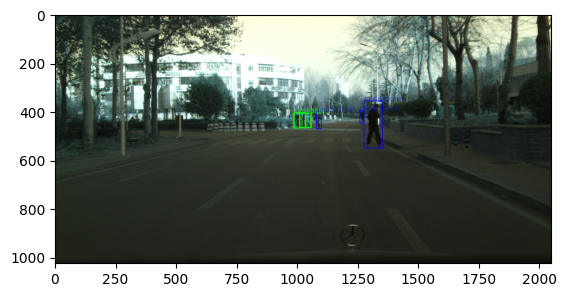

tensor([0.9124, 0.6649, 0.5954, 0.5766, 0.5718, 0.5141, 0.4987, 0.4871, 0.4625,
        0.4276, 0.4220, 0.4074, 0.3729, 0.3669, 0.3577, 0.3356, 0.3287, 0.3084,
        0.3037, 0.2908, 0.2866, 0.2545, 0.2486, 0.2463, 0.2349, 0.2254, 0.2253,
        0.2178, 0.2172, 0.2093, 0.2007, 0.1936, 0.1865, 0.1861, 0.1819, 0.1666,
        0.1646, 0.1618, 0.1550, 0.1481, 0.1480, 0.1460, 0.1328, 0.1273, 0.1265,
        0.1236, 0.1201, 0.1039, 0.1024, 0.1000, 0.0988, 0.0840, 0.0825, 0.0817,
        0.0813, 0.0790, 0.0784, 0.0778, 0.0754, 0.0704, 0.0697, 0.0663, 0.0659,
        0.0639, 0.0637, 0.0598, 0.0592, 0.0572, 0.0553, 0.0549, 0.0534, 0.0532,
        0.0519, 0.0514, 0.0502], grad_fn=<IndexBackward0>)


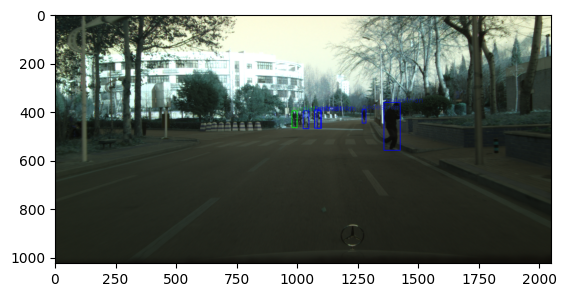

tensor([0.9431, 0.6957, 0.5884, 0.5804, 0.5394, 0.5363, 0.4988, 0.4095, 0.3705,
        0.3495, 0.3299, 0.3275, 0.3200, 0.3109, 0.2947, 0.2895, 0.2833, 0.2486,
        0.2483, 0.2272, 0.1832, 0.1796, 0.1660, 0.1559, 0.1554, 0.1387, 0.1302,
        0.1258, 0.1105, 0.1100, 0.1072, 0.0875, 0.0862, 0.0827, 0.0796, 0.0794,
        0.0727, 0.0692, 0.0623, 0.0558, 0.0552, 0.0539],
       grad_fn=<IndexBackward0>)


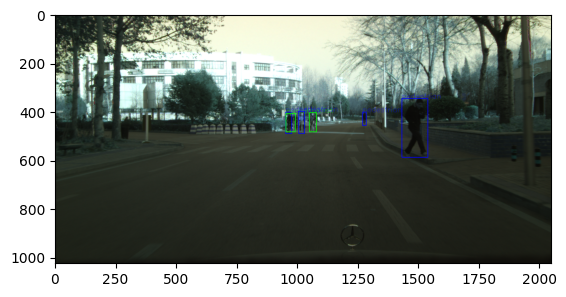

tensor([0.9112, 0.7782, 0.6906, 0.6682, 0.6191, 0.4581, 0.4563, 0.3694, 0.3311,
        0.3255, 0.3244, 0.3238, 0.3130, 0.2940, 0.2648, 0.2554, 0.2019, 0.1778,
        0.1617, 0.1529, 0.1352, 0.1301, 0.1268, 0.1219, 0.1180, 0.1101, 0.1076,
        0.0989, 0.0929, 0.0925, 0.0840, 0.0791, 0.0757, 0.0757, 0.0742, 0.0697,
        0.0598, 0.0593, 0.0546, 0.0545, 0.0513, 0.0510],
       grad_fn=<IndexBackward0>)


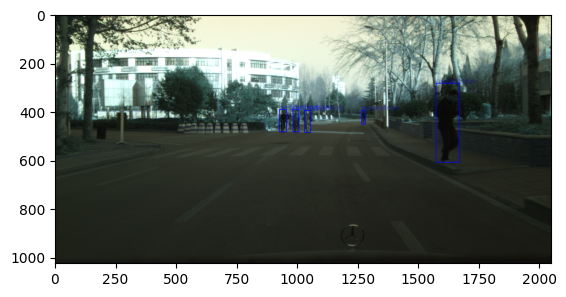

tensor([0.9079, 0.8620, 0.7957, 0.7230, 0.4984, 0.4705, 0.4623, 0.3991, 0.3573,
        0.3229, 0.3046, 0.2797, 0.1960, 0.1441, 0.1204, 0.1198, 0.1125, 0.1030,
        0.1016, 0.0961, 0.0907, 0.0719, 0.0682, 0.0622, 0.0584, 0.0584, 0.0579,
        0.0578, 0.0573, 0.0552, 0.0551, 0.0543, 0.0541],
       grad_fn=<IndexBackward0>)


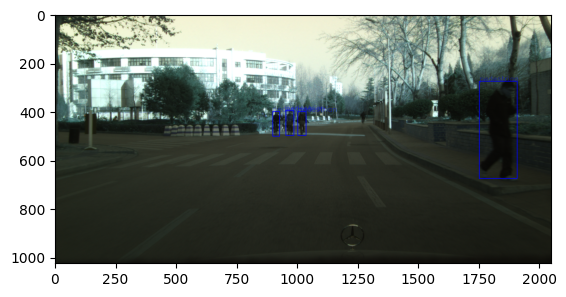

tensor([0.8002, 0.7623, 0.7022, 0.6039, 0.5354, 0.4588, 0.4178, 0.4177, 0.4153,
        0.3711, 0.3359, 0.3005, 0.2572, 0.1742, 0.1591, 0.1502, 0.1228, 0.1145,
        0.1109, 0.0947, 0.0866, 0.0858, 0.0855, 0.0824, 0.0747, 0.0736, 0.0730,
        0.0703, 0.0693, 0.0654, 0.0612, 0.0596, 0.0587, 0.0560, 0.0530, 0.0510,
        0.0507], grad_fn=<IndexBackward0>)


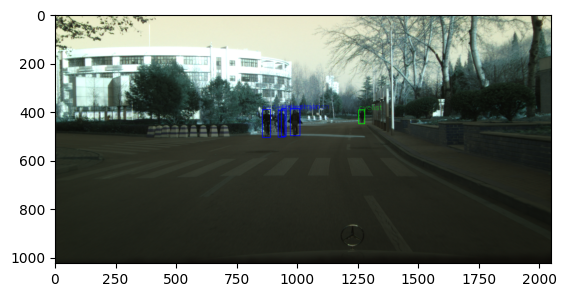

tensor([0.8659, 0.8334, 0.7115, 0.6546, 0.6396, 0.6066, 0.4256, 0.4028, 0.3318,
        0.2919, 0.2743, 0.2725, 0.1929, 0.1806, 0.1618, 0.1452, 0.1309, 0.1232,
        0.1214, 0.1189, 0.1142, 0.1127, 0.1076, 0.1019, 0.0917, 0.0871, 0.0818,
        0.0588, 0.0584, 0.0568], grad_fn=<IndexBackward0>)


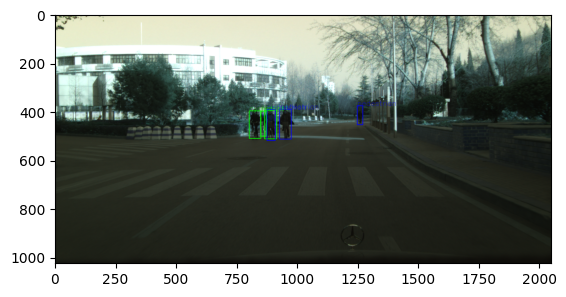

tensor([0.9634, 0.7463, 0.7311, 0.6603, 0.5003, 0.4383, 0.4342, 0.4033, 0.3763,
        0.3517, 0.3095, 0.2070, 0.1786, 0.1684, 0.1630, 0.1484, 0.1279, 0.1225,
        0.1185, 0.1070, 0.1014, 0.0954, 0.0839, 0.0765, 0.0620, 0.0605, 0.0578,
        0.0572, 0.0549, 0.0545, 0.0535, 0.0527, 0.0526, 0.0519, 0.0507, 0.0501],
       grad_fn=<IndexBackward0>)


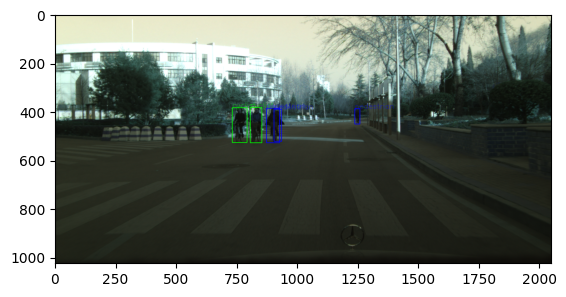

In [16]:
new_labels_list = ['__background__','pedestrian', 'cyclist', 'other']

rcnn.eval()
for i in range(30):
    X = images[i+210]
    X_vis = (X.detach().numpy().transpose(1, 2, 0)*255).astype(np.int32).copy()
    z = rcnn([X])
    boxes, labels, scores = z[0]['boxes'], z[0]['labels'], z[0]['scores']
    print(scores)
    for box, label, score in zip(boxes.detach().numpy(), labels.detach().numpy(), scores.detach().numpy()):
        if score < 0.5: 
            continue
        #print(box, label)
        color = (255, 255, 255)
        if labels_list[label] == 'cyclist':
            color = (0, 255, 0)
        elif labels_list[label] == 'pedestrian':
            color = (0, 0, 255)
        bbox = [int(pt) for pt in box]
        cv2.rectangle(X_vis, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness=2)
        cv2.putText(X_vis, new_labels_list[label], (bbox[0], bbox[1]), color=color, fontFace=0, fontScale=1)
    cv2.imwrite('images3/'+str(i)+'.png', X_vis)
    plt.imshow(X_vis)
    plt.show()

Let's also plot the training curve

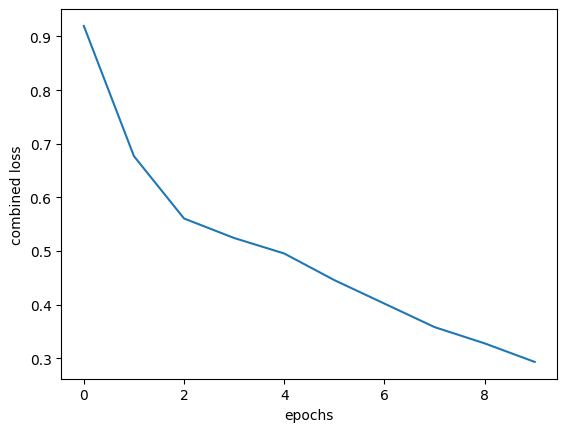

In [20]:
fig, ax = plt.subplots()

ax.plot(list(range(10)), loss_list)
ax.set_ylabel('combined loss')
ax.set_xlabel('epochs')

plt.show()